In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numba

In [178]:
model_names = [
#    'rawpredictions/lgb0.csv',
#    'rawpredictions/lgb1.csv',
#    'rawpredictions/lgb2.csv',
#    'rawpredictions/lgb3.csv',
#    'rawpredictions/lgb4.csv',
#    'rawpredictions/lgb5.csv',
#    'rawpredictions/lgb6.csv',
#    'rawpredictions/lgb7.csv',
#    'rawpredictions/lgb8.csv',
#    'rawpredictions/lgb9.csv'
#    'rawpredictions/glove_moredata0.csv',
#    'rawpredictions/glove_moredata1.csv',
#    'rawpredictions/glove_moredata2.csv',
#    'rawpredictions/glove_moredata3.csv',
#    'rawpredictions/glove_testing4.csv',
#    'rawpredictions/glove_testing5.csv',
#    'rawpredictions/glove_testing6.csv',
#    'rawpredictions/glove_moredata7.csv',
#    'rawpredictions/glove_moredata8.csv'
    'rawpredictions/sh1ng0.csv',
    'rawpredictions/sh1ng1.csv',
    'rawpredictions/sh1ng2.csv',
    'rawpredictions/sh1ng3.csv',
    'rawpredictions/sh1ng4.csv',
    'rawpredictions/sh1ng5.csv',
    'rawpredictions/sh1ng6.csv',
    'rawpredictions/sh1ng7.csv',
    'rawpredictions/sh1ng8.csv',
    'rawpredictions/sh1ng9.csv'
]
nmodels = len(model_names)

In [6]:
def read_models(model_names, namestring):
    nmodels = len(model_names)
    for i in range(nmodels):
        if i == 0:
            df = pd.read_csv(model_names[i])
            df['prediction_0'] = np.log(df.prediction / (1 - df.prediction))
            df.drop('prediction', axis=1, inplace=True)
        else:
            df_temp = pd.read_csv(model_names[i])
            df_temp.prediction = np.log(df_temp.prediction / (1 - df_temp.prediction))
            df['prediction_' + str(i)] = df_temp.prediction
        print('loaded', i)
    df['predict_'+namestring] = df.loc[:, 'prediction_0':'prediction_'+str(nmodels-1)].mean(axis=1)
    return df

In [7]:
df_xgb = read_models([
       'rawpredictions/glove_moredata0.csv',
    'rawpredictions/glove_moredata1.csv',
    'rawpredictions/glove_moredata2.csv',
    'rawpredictions/glove_moredata3.csv',
    'rawpredictions/glove_testing4.csv',
    'rawpredictions/glove_testing5.csv',
    'rawpredictions/glove_testing6.csv',
    'rawpredictions/glove_moredata7.csv',
    'rawpredictions/glove_moredata8.csv'
], 'xgb')

loaded 0
loaded 1
loaded 2
loaded 3
loaded 4
loaded 5
loaded 6
loaded 7
loaded 8


In [8]:
df_lgbm = read_models([
    'rawpredictions/lgb0.csv',
    'rawpredictions/lgb1.csv',
    'rawpredictions/lgb2.csv',
    'rawpredictions/lgb3.csv',
    'rawpredictions/lgb4.csv',
    'rawpredictions/lgb5.csv',
    'rawpredictions/lgb6.csv',
    'rawpredictions/lgb7.csv',
    'rawpredictions/lgb8.csv',
    'rawpredictions/lgb9.csv'
], 'lgbm')

loaded 0
loaded 1
loaded 2
loaded 3
loaded 4
loaded 5
loaded 6
loaded 7
loaded 8
loaded 9


In [9]:
df_sh1ng = read_models([
    'rawpredictions/sh1ng0.csv',
    'rawpredictions/sh1ng1.csv',
    'rawpredictions/sh1ng2.csv',
    'rawpredictions/sh1ng3.csv',
    'rawpredictions/sh1ng4.csv',
    'rawpredictions/sh1ng5.csv',
    'rawpredictions/sh1ng6.csv',
    'rawpredictions/sh1ng7.csv',
    'rawpredictions/sh1ng8.csv',
    'rawpredictions/sh1ng9.csv'
], 'sh1ng')



loaded 0
loaded 1
loaded 2
loaded 3
loaded 4
loaded 5
loaded 6
loaded 7
loaded 8
loaded 9


In [153]:
df_glove = read_models([
    'rawpredictions/glove_ind0.csv',
    'rawpredictions/glove_ind1.csv',
    'rawpredictions/glove_ind2.csv',
    'rawpredictions/glove_ind3.csv',
    'rawpredictions/glove_ind4.csv',
    'rawpredictions/glove_ind5.csv',
    'rawpredictions/glove_ind6.csv',
    'rawpredictions/glove_ind7.csv',
    'rawpredictions/glove_ind8.csv',
    'rawpredictions/glove_ind9.csv'
], 'glove')



loaded 0
loaded 1
loaded 2
loaded 3
loaded 4
loaded 5
loaded 6
loaded 7
loaded 8
loaded 9


In [180]:
df = (df_xgb.drop(['prediction_'+str(s) for s in range(9)], axis=1)
      .merge(df_lgbm[['user_id', 'product_id', 'predict_lgbm']], on=['user_id', 'product_id'])
          #.merge(df_glove[['user_id', 'product_id', 'predict_glove']], on=['user_id', 'product_id'])
      .merge(df_sh1ng[['user_id', 'product_id', 'predict_sh1ng']], on=['user_id', 'product_id']))



In [181]:
from sklearn.linear_model import LogisticRegression

In [182]:
model = LogisticRegression()

In [183]:
from sklearn.preprocessing import StandardScaler

In [184]:
#X_train, X_test, y_train, y_test = train_test_split(df.query('eval_set=="train"')[['prediction_xgb', 'prediction_lgbm', 'prediction_sh1ng']].values,
#                                                    df.query('eval_set=="train"')['reordered'], test_size=.33)

In [185]:
X_train = df.query('eval_set=="train"')[['predict_xgb', 'predict_lgbm', 'predict_sh1ng']].values
y_train = df.query('eval_set=="train"')['reordered']

In [186]:
X_test = df.query('eval_set=="test"')[['predict_xgb', 'predict_lgbm', 'predict_sh1ng']].values


In [187]:
standard = StandardScaler()
#poly = PolynomialFeatures(degree=2, include_bias=False)

In [188]:
X_train = standard.fit_transform(X_train)
#X_train = poly.fit_transform(X_train)

In [189]:
X_test = standard.transform(X_test)
#X_test = poly.transform(X_test)

In [190]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [191]:
model.coef_

array([[ 0.90777016, -0.34147385,  0.88886671]])

In [192]:
df['prediction'] = 0

In [193]:
df.loc[df.eval_set=="test", 'prediction'] = model.decision_function(X_test)
df.loc[df.eval_set=="train", 'prediction'] = model.decision_function(X_train)

In [194]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train,
              model.decision_function(X_train))


0.84123373070079388

In [195]:
df['prob'] = 1.0 / (1 + np.exp(-df.prediction))

In [196]:
none_df = pd.read_csv('rawpredictions/nones.csv')
none_df['none_prob'] = none_df.prediction

In [197]:
#df_extrapredictions = df_extrapredictions.merge(none_df.query('eval_set=="test"')[['order_id', 'none_prob']], on='order_id', how='right')

In [198]:
#df_extrapredictions['prob'] = df_extrapredictions.prediction

In [199]:
df = df.merge(none_df[['order_id', 'none_prob']], on='order_id')

In [36]:
@numba.jit
def GFM_numba(probs, noneprob, nsamples=10000, nruns=1):
    nprobs = probs.shape[0]
    extra_none = 0
    newprobs = probs.copy()
    while extra_none + (1-extra_none) * np.prod(1-newprobs) < noneprob:
        extra_none = extra_none + .0001
        newprobs = np.minimum(probs / (1 - extra_none), 1)
    probs = newprobs
    W = np.zeros((nprobs+1, nprobs+1))
    for i in range(nprobs+1):
        for j in range(nprobs+1):
            W[i, j] = 1.0 / (i + j + 2.0)

    expF1 = np.zeros((nruns))
    prediction = np.zeros((nruns, nprobs+1))
    for r in range(nruns):
        samples = (np.random.rand(nsamples, nprobs) < probs * np.ones((nsamples, nprobs))).astype(int)
        samples[:np.random.binomial(nsamples, extra_none),:] = 0
        samples = np.concatenate((samples, (samples.sum(1) == 0).astype(int).reshape((nsamples, 1))), axis=1)
        sums = samples.sum(1) - 1
        P = np.zeros((nprobs + 1, nprobs + 1))
        for i in range(nsamples):
            s = sums[i]
            P[s] = P[s] + samples[i]
        P = P.transpose()
        P = P / nsamples
        F = np.dot(P, W)
        m = P.shape[0]
        expectedF1s = np.zeros((m))
        for k in range(m):
            f = F[:,k]
            h = np.zeros((m))
            h[np.flip(np.argsort(f), axis=0)[:(k+1)]] = 1
            expectedF1s[k] = 2 * np.dot(h, f)
        k = np.argmax(expectedF1s)
        expF1[r] = expectedF1s[k]
        f = F[:,k]
        prediction[r, np.flip(np.argsort(f), axis=0)[:(k+1)]] = 1
    return prediction[:, :-1], prediction[:, -1], expF1

In [37]:
def GFM_wrapper(df, nsamples=10000, nruns=1):
    probs = df['prob'].values
    noneprob = df['none_prob'].values[0]
    prediction, putnone, expF1 = GFM_numba(probs, noneprob, nsamples, nruns)
    if nruns == 1:
        df['prediction'] = prediction[0,:]
        df['putnone'] = putnone[0]
    else:
        for i in range(nruns):
            df['prediction_'+str(i)] = prediction[i,:]
            df['putnone_'+str(i)] = putnone[i]
            #df['expF1'] = expF1[0]
    return df

In [38]:
def GFM(df, nsamples=1000):
    probs = df['prob'].values
    nprobs = probs.shape[0]
    noneprob = df['none_prob'].values[0]
    extra_none = 0
    newprobs = probs.copy()
    while extra_none + (1-extra_none) * np.prod(1-newprobs) < noneprob:
        extra_none = extra_none + .0001
        newprobs = np.minimum(probs / (1 - extra_none), 1)
    probs = newprobs
    samples = (np.random.rand(nsamples, nprobs) < probs * np.ones((nsamples, nprobs))).astype(int)
    samples[:np.random.binomial(nsamples, extra_none),:] = 0
    samples = np.concatenate((samples, (samples.sum(1) == 0).astype(int).reshape((nsamples, 1))), axis=1)
    sums = samples.sum(1) - 1
    P = {}
    for i in range(nprobs+1):
        P[i] = np.zeros((nprobs+1))
    
    #P = np.zeros((probs.shape[0] + 1, probs.shape[0] + 1))
    for i in range(nsamples):
        s = sums[i]
        P[s] = P[s] + samples[i]
    #for i in range(nsamples):
    #    P[:, sums[i]] = P[:, sums[i]] + samples[i, :]
    P = np.array([x for x in P.values()])
    P = P.transpose()
    P = P / nsamples
    W = np.zeros(P.shape)
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i, j] = 1.0 / (i + j + 2.0)
    F = np.dot(P, W)
    m = P.shape[0]
    expectedF1s = np.zeros((m))
    for k in range(m):
        f = F[:,k]
        h = np.zeros((m))
        h[np.flip(np.argsort(f), axis=0)[:(k+1)]] = 1
        expectedF1s[k] = 2 * np.dot(h, f)
    k = np.argmax(expectedF1s)
    expF1 = expectedF1s[k]
    f = F[:,k]
    prediction = np.zeros((m))
    prediction[np.flip(np.argsort(f), axis=0)[:(k+1)]] = 1
    df['prediction'] = prediction[:-1]
    df['putnone'] = prediction[-1]
    df['expF1'] = expF1
    return df

In [39]:
def EXP_wrapper(df):
    probs = df['prob'].values
    noneprob = df['none_prob'].values[0]
    k, putnone, expF1 = EXP(probs, noneprob)
    #df['prediction'] = prediction[0,:]
    idx = np.argsort(probs)[::-1]
    df['prediction'] = 0
    df.iloc[idx, :]['prediction'] = 1
    df['putnone'] = 1.0*putnone
    return df

@numba.jit
def EXP(P, pNone):
    expectations = []
    P = np.sort(P)[::-1]

    n = np.array(P).shape[0]
    DP_C = np.zeros((n + 2, n + 1))
    #if pNone is None:
    #    pNone = (1.0 - P).prod()

    DP_C[0, 0] = 1.0
    for j in range(1, n):
        DP_C[0, j] = (1.0 - P[j - 1]) * DP_C[0, j - 1]

    for i in range(1, n + 1):
        DP_C[i, i] = DP_C[i - 1, i - 1] * P[i - 1]
        for j in range(i + 1, n + 1):
            DP_C[i, j] = P[j - 1] * DP_C[i - 1, j - 1] + (1.0 - P[j - 1]) * DP_C[i, j - 1]

    DP_S = np.zeros((2 * n + 1,))
    DP_SNone = np.zeros((2 * n + 1,))
    for i in range(1, 2 * n + 1):
        DP_S[i] = 1. / (1. * i)
        DP_SNone[i] = 1. / (1. * i + 1)
    for k in range(n + 1)[::-1]:
        f1 = 0
        f1None = 0
        for k1 in range(n + 1):
            f1 += 2 * k1 * DP_C[k1][k] * DP_S[k + k1]
            f1None += 2 * k1 * DP_C[k1][k] * DP_SNone[k + k1]
        for i in range(1, 2 * k - 1):
            DP_S[i] = (1 - P[k - 1]) * DP_S[i] + P[k - 1] * DP_S[i + 1]
            DP_SNone[i] = (1 - P[k - 1]) * DP_SNone[i] + P[k - 1] * DP_SNone[i + 1]
        expectations.append([f1None + 2 * pNone / (2 + k), f1])

    expectations = np.array(expectations[::-1]).T

    ix_max = np.unravel_index(expectations.argmax(), expectations.shape)
    max_f1 = expectations[ix_max]

    predNone = True if ix_max[0] == 0 else False
    best_k = ix_max[1]

    return best_k, predNone, max_f1


In [40]:
#test_df = df.query('eval_set=="train" and user_id<1000')[['order_id', 'product_id', 'prob', 'none_prob']].copy()


In [ ]:
%%time
#test_df = df.query('validation_set==10 and user_id < 500').loc[:, ['user_id', 'product_id', 'order_id', 'prob', 'none_prob', 'reordered']].copy()
test_df = df.query('eval_set=="test"')[['order_id', 'product_id', 'prob', 'none_prob']].copy()
#test_df = df.query('validation_set==10').loc[:, ['user_id', 'product_id', 'order_id', 'prob', 'none_prob', 'reordered']].copy()
#test_df = df.query('user_id==1').loc[:, ['user_id', 'product_id', 'order_id', 'prob', 'none_prob', 'reordered']].copy()
test_df = test_df.groupby('order_id').apply(GFM_wrapper, nsamples=1000, nruns=50)

(4833292, 6)

In [150]:
test_df_short.prob.describe()

count    2066.000000
mean        0.097525
std         0.123365
min         0.001917
25%         0.023945
50%         0.052989
75%         0.114719
max         0.882139
Name: prob, dtype: float64

In [152]:
test_df_short.loc[:, ['prediction_'+str(i) for i in range(50)]].sum(axis=1).describe()

count    1736.000000
mean        7.770737
std        17.527956
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        50.000000
dtype: float64

In [91]:
gfm_df = test_df

In [92]:
gfm_df['hit'] = gfm_df.prediction * gfm_df.reordered
gfm_df_agg = gfm_df.groupby('user_id').agg({'reordered': np.sum,
                                    'prediction': np.sum,
                                    'hit': np.sum,
                               #'expF1': np.mean,
                               'putnone': np.mean})
gfm_df_agg['truenone'] = (gfm_df_agg.reordered == 0)
gfm_df_agg.putnone = gfm_df_agg.putnone.astype(bool)
gfm_df_agg['r'] = gfm_df_agg.reordered
gfm_df_agg['p'] = gfm_df_agg.prediction
gfm_df_agg['h'] = gfm_df_agg.hit
gfm_df_agg.loc[gfm_df_agg.putnone & gfm_df_agg.truenone, "h"] = 1
gfm_df_agg.loc[gfm_df_agg.putnone, 'p'] = gfm_df_agg.loc[gfm_df_agg.putnone, 'p'] + 1
gfm_df_agg.loc[gfm_df_agg.truenone, 'r'] = gfm_df_agg.loc[gfm_df_agg.truenone, 'r'] + 1
gfm_df_agg['precision'] = (gfm_df_agg['h']) / (gfm_df_agg['p'])
gfm_df_agg['recall'] = (gfm_df_agg['h']) / (gfm_df_agg['r'])
gfm_df_agg['f1'] = 2 * gfm_df_agg['precision'] * gfm_df_agg['recall'] / (gfm_df_agg['precision'] + gfm_df_agg['recall'] + .000001)
gfm_df_agg.f1.mean()

0.41741372435234497

In [81]:
order_sample = pd.Series(test_df.order_id.unique()).sample(test_df.order_id.unique().shape[0], replace=True)

In [172]:
test_df['rowcount'] = 1

In [176]:
f1means = []
n = 50
test_df['putnone'] = (test_df.loc[:, ['putnone_'+str(i) for i in range(n)]].sum(axis=1) > 25).astype(float)
#test_df['prediction'] = (test_df.loc[:, ['prediction_'+str(i) for i in range(n)]].sum(axis=1) > 25).astype(float)

for i in range(50):
    test_df['prediction'] = (test_df.loc[:, ['prediction_'+str(i) for i in range(n)]].sum(axis=1) > i).astype(float)
    #test_df['putnone'] = (test_df.loc[:, ['putnone_'+str(i) for i in range(n)]].sum(axis=1) > i).astype(float)
    #test_df_short['prediction'] = test_df_short['prediction_'+str(i)]
    gfm_df = test_df
    #test_df['putnone'] = test_df['putnone_'+str(i)]

    gfm_df['hit'] = gfm_df.prediction * gfm_df.reordered
    gfm_df_agg = gfm_df.groupby('order_id').agg({'reordered': np.sum,
                                        'prediction': np.sum,
                                        'hit': np.sum,
                                                 'rowcount':'count',
                                   #'expF1': np.mean,
                                   'putnone': np.mean})
    gfm_df_agg['truenone'] = (gfm_df_agg.reordered == 0)
    gfm_df_agg.putnone = gfm_df_agg.putnone.astype(bool)
    gfm_df_agg['r'] = gfm_df_agg.reordered
    gfm_df_agg['p'] = gfm_df_agg.prediction
    gfm_df_agg['h'] = gfm_df_agg.hit
    gfm_df_agg.loc[gfm_df_agg.putnone & gfm_df_agg.truenone, "h"] = 1
    gfm_df_agg.loc[gfm_df_agg.putnone, 'p'] = gfm_df_agg.loc[gfm_df_agg.putnone, 'p'] + 1
    gfm_df_agg.loc[gfm_df_agg.truenone, 'r'] = gfm_df_agg.loc[gfm_df_agg.truenone, 'r'] + 1
    gfm_df_agg['precision'] = (gfm_df_agg['h']) / (gfm_df_agg['p'])
    gfm_df_agg['recall'] = (gfm_df_agg['h']) / (gfm_df_agg['r'])
    gfm_df_agg['f1'] = 2 * gfm_df_agg['precision'] * gfm_df_agg['recall'] / (gfm_df_agg['precision'] + gfm_df_agg['recall'] + .000001)
    #f1means.append(gfm_df_agg.f1[order_sample.tolist()].mean())
    f1means.append(gfm_df_agg.query('rowcount > 100').f1.mean())

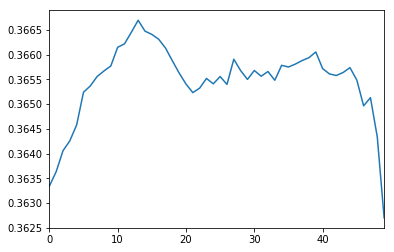

In [177]:
pd.Series(f1means).plot()

In [ ]:
0.40277400192840485

In [101]:
gfm_df_agg.expF1.mean()

0.40901485626450229

In [ ]:
0.41123559846785912

In [247]:
test_df['putnone'] = (test_df.loc[:, ['putnone_'+str(i) for i in range(n)]].sum(axis=1) > 25).astype(float)
test_df['prediction'] = (test_df.loc[:, ['prediction_'+str(i) for i in range(n)]].sum(axis=1) > 15).astype(float)


In [248]:
writenone_df = test_df.groupby('order_id').agg({'putnone': np.mean}).reset_index()

In [249]:
writenone_df['nonestring'] = ''
writenone_df.loc[writenone_df.putnone == 1, 'nonestring'] = 'None'


In [250]:
writenone_df.nonestring.describe()

count     75000
unique        2
top            
freq      62304
Name: nonestring, dtype: object

In [251]:
prediction_df = test_df.query('prediction == 1').copy()
prediction_df = prediction_df[['order_id', 'product_id']]

In [252]:
prediction_df.shape

(705255, 2)

In [253]:
prediction_lists = None

In [254]:
prediction_lists = prediction_df.groupby('order_id').agg(lambda x: " ".join(x.astype(str))).reset_index()
prediction_lists = prediction_lists.merge(writenone_df[['order_id', 'nonestring']], on='order_id', how='right')
prediction_lists['products'] = prediction_lists.product_id.fillna('')
prediction_lists['products'] = prediction_lists.products + " " + prediction_lists.nonestring

prediction_lists = prediction_lists[['order_id', 'products']]
prediction_lists.to_csv("submissions/stacked_1000x50.csv", index=False)


In [219]:
prediction_lists.head()

,order_id,products
0,17,21709 47766 38777 21463 13107
1,34,13176 21137 47792 47766 18618 44663 39475 1608...
2,137,41787 24852 25890 5134 38689 2326 23794
3,182,47209 39275 47672 33000 11520 41149 5479 13629...
4,257,49235 24852 27966 13870 21137 45013 27104 4605...


In [221]:
test_df

,order_id,product_id,prob,none_prob,prediction_0,putnone_0,prediction_1,putnone_1,prediction_2,putnone_2,...,prediction_46,putnone_46,prediction_47,putnone_47,prediction_48,putnone_48,prediction_49,putnone_49,putnone,prediction
0,363822,196,0.264317,0.023145,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,363822,6187,0.111278,0.023145,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,363822,16696,0.274176,0.023145,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,363822,48812,0.106336,0.023145,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,363822,4562,0.055657,0.023145,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,363822,24852,0.206990,0.023145,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
6,363822,47966,0.123511,0.023145,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,363822,43154,0.120028,0.023145,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,363822,43772,0.072469,0.023145,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,363822,31981,0.103830,0.023145,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
